In [2]:
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pkg_resources
from numpy import ndarray
from numpy.typing import NDArray
from dataclasses import dataclass
from typing import Callable, List, Optional


In [3]:
from trachoma.trachoma_functions_age import *
import multiprocessing
from joblib import Parallel, delayed
import pkg_resources
num_cores = multiprocessing.cpu_count()

#############################################################################################################################
#############################################################################################################################

# initialize parameters, sim_params, and demography

params = {'N': 10000,
          'av_I_duration' : 2,
          'av_ID_duration':200/7,
          'inf_red':0.45,
          'min_ID':11, #Parameters relating to duration of infection period, including ID period
          'av_D_duration':300/7,
          'min_D':1, #Parameters relating to duration of disease period
          'v_1':1,
          'v_2':2.6,
          'phi':1.4,
          'epsilon':0.5,#Parameters relating to lambda function- calculating force of infection
          #Parameters relating to MDA
          'MDA_Cov':0.8,
          'MDA_Eff': 0.85, # Efficacy of treatment
          'rho':0.3,
          'nweeks_year':52,
          'babiesMaxAge':0.5, #Note this is years, need to check it converts to weeks later
          'youngChildMaxAge':9,#Note this is years, need to check it converts to weeks later
          'olderChildMaxAge':15, #Note this is years, need to check it converts to weeks later
          'b1':1,#this relates to bacterial load function
          'ep2':0.114,
          'n_inf_sev':38,
          'TestSensitivity': 0.96,
          'TestSpecificity': 0.965,
          'SecularTrendIndicator': 0,
          'SecularTrendYearlyBetaDecrease': 0.01,
          'vacc_prob_block_transmission':  0.5, 
          'vacc_reduce_bacterial_load': 0.5, 
          'vacc_reduce_duration': 0.5,
          'vacc_coverage': 0,  
          'vacc_waning_length': 52 * 5}


burnin = 100*52
timesim = burnin + 21*52

sim_params = {'timesim': timesim, 
              'burnin': burnin,
              'N_MDA':5, # irrelevant due to input method
              'n_sim':100}


demog = {'tau': 0.0004807692, 
         'max_age': 3120,
         'mean_age': 1040}



previous_rounds = 0


Start_date = date(2010,1, 1)
End_date = date(2030,12,31)


## Modifying Matt's updated run folder to include the version of sim_Ind_MDA which includes vaccination. Need to update/match inputs for SimulationFunction.

In [4]:
def seed_to_state(seed):
    np.random.seed(seed)
    return np.random.get_state()

outputYear = range(2019, 2041) # CHECK this, was 2019 to 2041
outputTimes = getOutputTimes(outputYear)
outputTimes = get_Intervention_times(outputTimes, Start_date, sim_params['burnin'])

# this is essentially the same as the original version of the Trachoma_Simulation function

def SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump, beta):

    # Longitudinal simulations:

    # Setting beta; the higher this is the higher the prevalence. 0.12 has prevalence around 20%
    #bet = np.random.uniform(size=sim_params['n_sim'], low=0.1, high=0.12)
    bet = np.ones(sim_params['n_sim']) * beta
    # Run multiple simulations
    def multiple_simulations(i):
        seed = i * seed_bump

        # Generate some random numbers
        np.random.seed(seed)
# we generate a numpy state for each simulation by saving a state. If the seed is set above, this will be consistent from run to run
        numpy_states = list(map(lambda s: seed_to_state(s), np.random.randint(2^32, size=1)))
        vals = Set_inits(params=params, demog=demog, sim_params = sim_params, MDAData=MDAData, numpy_state = numpy_states[0])    # Set initial conditions
        vals = Seed_infection(params=params, vals=vals) # Seed infection
        
        # vals = Check_and_init_MDA_and_survey_counts(vals, numpy_states[0])
        
        vals = Check_and_init_vaccination_state(params,vals)
        
        vals = Check_and_init_MDA_treatment_state(params, vals, MDAData, numpy_state=numpy_states[0])
        
        out, results = sim_Ind_MDA_Include_Survey(params, vals, timesim, burnin, demog, bet[i], MDA_times, MDAData, vacc_times, VaccData, outputTimes, doSurvey = False, doIHMEOutput = False, numpy_state = numpy_states[0])
        return out

    data_store_all_sim = Parallel(n_jobs=num_cores)(delayed(multiple_simulations)(i) for i in range(sim_params['n_sim']))

    return data_store_all_sim




# analyse the runs of the simulations
# we return some aggregated results along with the raw data
def analyseResults(data, sim_params):

    True_Prev_Infection_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Disease_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    #True_Prev_Disease = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    #True_Prev_Infection = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    Time = np.arange(sim_params['timesim'] )
    
    prev_diseases_ages = [np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim'])) for _ in range(10)]
    prev_infection_ages = [np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim'])) for _ in range(10)]
    
    for i in range(sim_params['n_sim']):

        #True_Prev_Disease[:, i] = data[i]['True_Prev_Disease'][0: sim_params['timesim']]
        #True_Prev_Infection[:, i] = data[i]['True_Prev_Infection'][0: sim_params['timesim']]
        True_Prev_Infection_children_1_9[:, i] = data[i]['True_Prev_Infection_children_1_9'][0: sim_params['timesim']]
        True_Prev_Disease_children_1_9[:, i] = data[i]['True_Prev_Disease_children_1_9'][0: sim_params['timesim']]
        
        for j in range(10):
            prev_diseases_ages[j][:, i] = data[i]['age_prevalences'][j][0: sim_params['timesim']]
            prev_infection_ages[j][:, i] = data[i]['age_infections'][j][0: sim_params['timesim']]

    
    results = pd.DataFrame({'Time': Time / 52,
                            'Mean_Disease_Children': np.mean(True_Prev_Disease_children_1_9, axis=1),
                            'Mean_Infection_Children': np.mean(True_Prev_Infection_children_1_9, axis=1),
                            #'Mean_Disease_All': np.mean(True_Prev_Disease, axis=1),
                            #'Mean_Infection_All': np.mean(True_Prev_Infection, axis=1),
                            'Median_Disease_Children': np.median(True_Prev_Disease_children_1_9, axis=1),
                            'Median_Infection_Children': np.median(True_Prev_Infection_children_1_9, axis=1),
                            #'Median_Disease_All': np.median(True_Prev_Disease, axis=1),
                            #'Median_Infection_All': np.median(True_Prev_Infection, axis=1)
                            'Median_Dis_0': np.median(prev_diseases_ages[0], axis=1),
                            'Median_Inf_0': np.median(prev_infection_ages[0], axis=1),
                            'Median_Dis_1': np.median(prev_diseases_ages[1], axis=1),
                            'Median_Inf_1': np.median(prev_infection_ages[1], axis=1),
                            'Median_Dis_2': np.median(prev_diseases_ages[2], axis=1),
                            'Median_Inf_2': np.median(prev_infection_ages[2], axis=1),
                            'Median_Dis_3': np.median(prev_diseases_ages[3], axis=1),
                            'Median_Inf_3': np.median(prev_infection_ages[3], axis=1),
                            'Median_Dis_4': np.median(prev_diseases_ages[4], axis=1),
                            'Median_Inf_4': np.median(prev_infection_ages[4], axis=1),
                            'Median_Dis_5': np.median(prev_diseases_ages[5], axis=1),
                            'Median_Inf_5': np.median(prev_infection_ages[5], axis=1),
                            'Median_Dis_6': np.median(prev_diseases_ages[6], axis=1),
                            'Median_Inf_6': np.median(prev_infection_ages[6], axis=1),
                            'Median_Dis_7': np.median(prev_diseases_ages[7], axis=1),
                            'Median_Inf_7': np.median(prev_infection_ages[7], axis=1),
                            'Median_Dis_8': np.median(prev_diseases_ages[8], axis=1),
                            'Median_Inf_8': np.median(prev_infection_ages[8], axis=1),
                            'Median_Dis_9': np.median(prev_diseases_ages[9], axis=1),
                            'Median_Inf_9': np.median(prev_infection_ages[9], axis=1),
                            })

    return results,True_Prev_Infection_children_1_9, True_Prev_Disease_children_1_9 #, True_Prev_Disease, True_Prev_Infection, 




# function to get the MDA data for the specified coverage file
def get_MDA_data(coverageFileName):
    MDAData = readPlatformData(coverageFileName, "MDA")
    MDA_dates = getInterventionDates(MDAData)
    MDA_times = get_Intervention_times(MDA_dates, Start_date, sim_params['burnin'])
    return MDAData, MDA_times

# function to get the vaccination data for the specified coverage file
def get_vacc_data(coverageFileName):
    VaccData = readPlatformData(coverageFileName, "Vaccine")
    vacc_dates = getInterventionDates(VaccData)
    vacc_times = get_Intervention_times(vacc_dates, Start_date, sim_params['burnin'])
    return VaccData, vacc_times

In [5]:

seed = 100
beta = 0.17


## Age prevalence plots

#### Scenario M1: No interruption

In [6]:
MDAData, MDA_times = get_MDA_data("scen1_no_interruption.csv")
VaccData, vacc_times = get_vacc_data("scen1_no_interruption.csv")
data_no_interruption = SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump = seed, beta = beta)
res_no_interruption = analyseResults(data_no_interruption, sim_params)

In [7]:
print(len(data_no_interruption))
print(len(data_no_interruption[0]))
print(data_no_interruption[0].keys())

100
29
dict_keys(['IndI', 'IndD', 'No_Inf', 'T_latent', 'T_ID', 'T_D', 'Ind_latent', 'Ind_ID_period_base', 'Ind_D_period_base', 'bact_load', 'Age', 'N_MDA', 'True_Prev_Disease_children_1_9', 'vaccinated', 'time_since_vaccinated', 'treatProbability', 'MDA_coverage', 'systematic_non_compliance', 'nSurvey', 'prevNSurvey', 'numVacc', 'nDosesVacc', 'coverageVacc', 'prevNVacc', 'Yearly_threshold_infs', 'True_Prev_Infection_children_1_9', 'State', 'age_prevalences', 'age_infections'])


In [79]:
print(MDA_times)

[5669 5721 5774 5826 5878 5930 5982 6034 6087 6139 6191 6243 6295 6347]


Text(0.5, 1.0, 'Prevalence of disease ages 1-9')

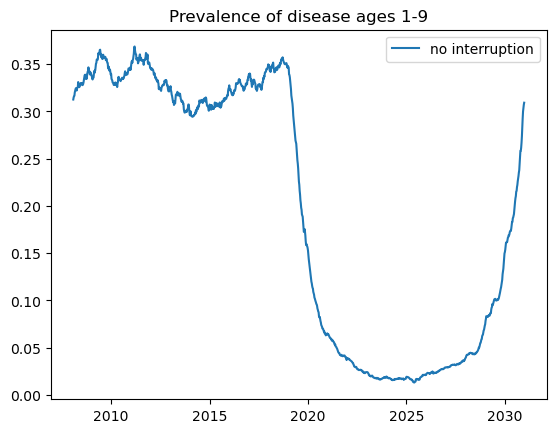

In [9]:
import matplotlib.pyplot as plt
start_year = 2010-burnin/52 # was 2018 - check to match csv dates
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.legend(['no interruption', 'interrupt no mitigation', 'interrupt with mitigation']) 
plt.title("Prevalence of disease ages 1-9")

Text(0.5, 1.0, 'Prevalence of infection ages 1-9')

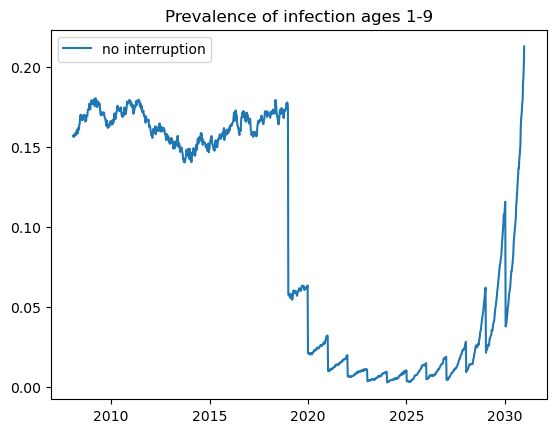

In [10]:
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]), np.array(res_no_interruption[0]['Median_Infection_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.legend(['no interruption', 'interrupt no mitigation', 'interrupt with mitigation']) 
plt.title("Prevalence of infection ages 1-9")

## Disease prevalence by age

Text(0.5, 1.0, 'Prevalence of disease by age')

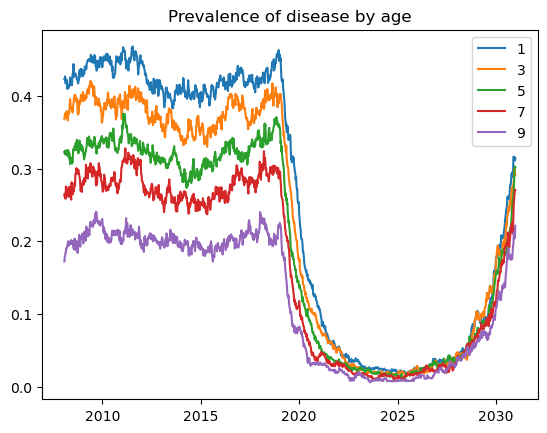

In [77]:
start_year = 2010-burnin/52 # was 2018 - check to match csv dates

ages = [1,3,5,7,9]

for i in ages:
    plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0]['Median_Dis_'+str(i)][(sim_params['burnin']-100): sim_params['timesim']]), label = str(i))


plt.legend() 
plt.title("Prevalence of disease by age")

## Infection prevalence by age

Text(0.5, 1.0, 'Prevalence of infection by age')

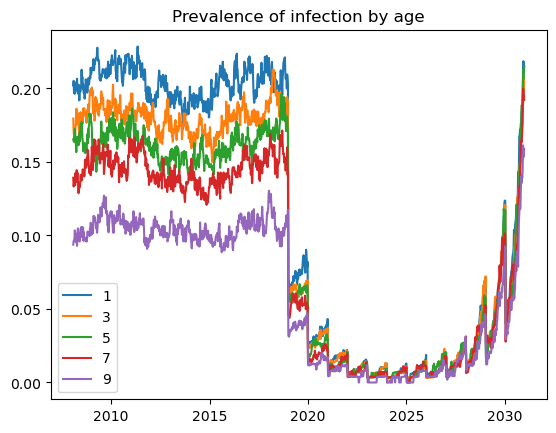

In [75]:
start_year = 2010-burnin/52 # was 2018 - check to match csv dates

ages = [1,3,5,7,9]

for i in ages:
    plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0]['Median_Inf_'+str(i)][(sim_params['burnin']-100): sim_params['timesim']]), label = str(i))

plt.legend() 
plt.title("Prevalence of infection by age")

## Infection prevalence distribution plots

In [55]:
# find MDA times, to know which weeks to plot
print(MDA_times)
data = res_no_interruption[0]

[5669 5721 5774 5826 5878 5930 5982 6034 6087 6139 6191 6243 6295 6347]


### Pre-MDA

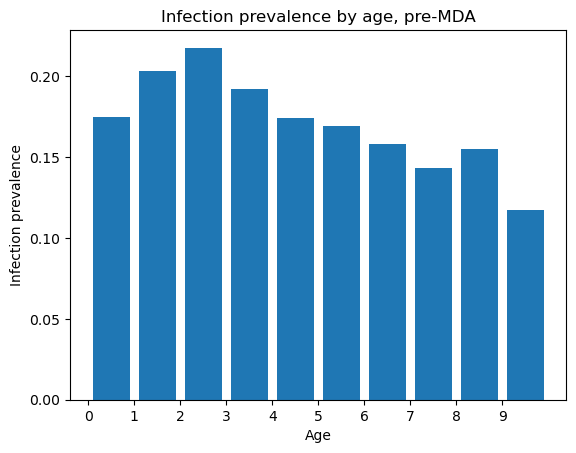

In [65]:
preinfs = [data['Median_Inf_' + str(i)][5667] for i in range(10)]

plt.bar([x+0.5 for x in range(10)], preinfs)
plt.xlabel('Age')
plt.ylabel('Infection prevalence')
plt.title('Infection prevalence by age, pre-MDA')
plt.xticks([i for i in range(10)]);

### After 3 years

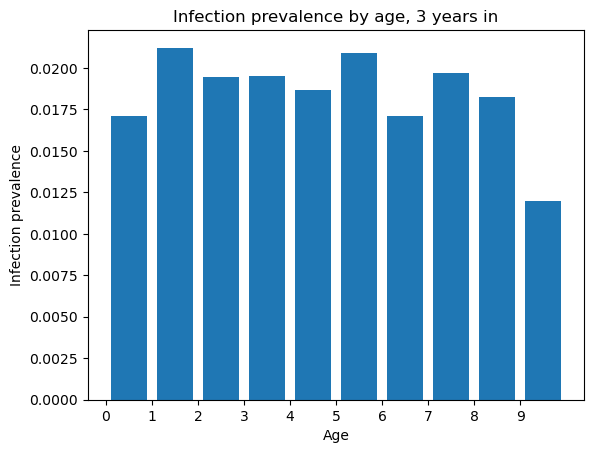

In [66]:
preinfs = [data['Median_Inf_' + str(i)][5824] for i in range(10)]
plt.bar([x+0.5 for x in range(10)], preinfs)
plt.xlabel('Age')
plt.ylabel('Infection prevalence')
plt.title('Infection prevalence by age, 3 years in')
plt.xticks([i for i in range(10)]);

### After 5 years

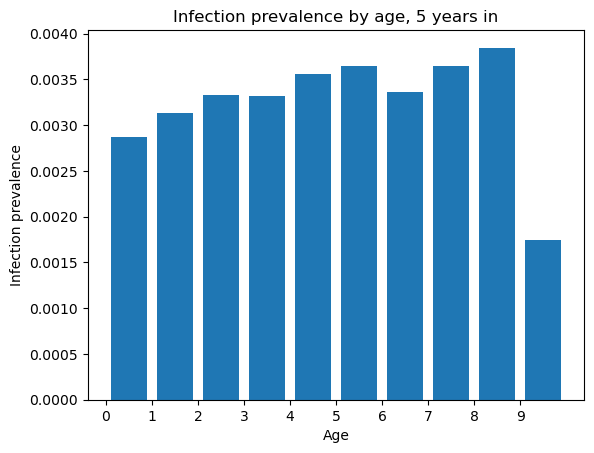

In [67]:
preinfs = [data['Median_Inf_' + str(i)][5938] for i in range(10)]
plt.bar([x+0.5 for x in range(10)], preinfs)
plt.xlabel('Age')
plt.ylabel('Infection prevalence')
plt.title('Infection prevalence by age, 5 years in')
plt.xticks([i for i in range(10)]);

### Post-MDA (3 years)

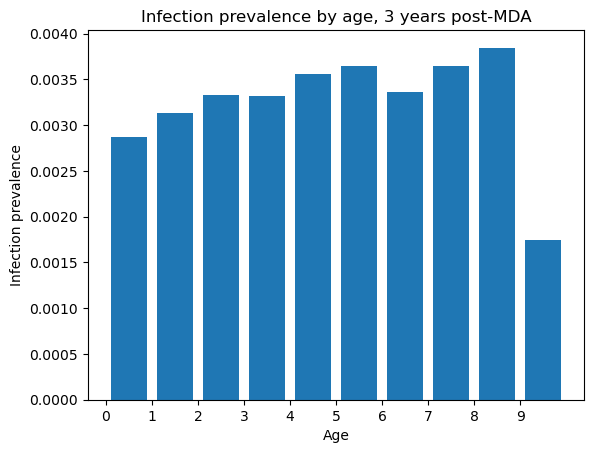

In [78]:
preinfs = [data['Median_Inf_' + str(i)][5938] for i in range(10)]
plt.bar([x+0.5 for x in range(10)], preinfs)
plt.xlabel('Age')
plt.ylabel('Infection prevalence')
plt.title('Infection prevalence by age, 3 years post-MDA')
plt.xticks([i for i in range(10)]);